In [1]:
%pylab inline
import numpy as np
from dPCA import dPCA

Populating the interactive namespace from numpy and matplotlib


We first build surrogate data to apply dPCA to.

In [2]:
## Change D here to see if the signifcance_analysis scales with n_features > 1 (excl time)
# (and run entire notebook)

# D = 1
D = 2

In [3]:
# number of neurons, time-points and stimuli and decisions
N, T, S = 100, 250, 6

# noise-level and number of trials in each condition
noise, n_samples = 0.2, 10

# build two latent factors
zt = (np.arange(T) / float(T))
zs = (np.arange(S) / float(S))
zd = (np.arange(D) / float(D))

# build trial-by trial data
trialR = noise * np.random.randn(n_samples, N, S, D, T)
trialR += np.random.randn(N)[None, :, None, None, None] * zt[None, None, None, None, :]
trialR += np.random.randn(N)[None, :, None, None, None] * zs[None, None, :, None, None]
trialR += np.random.randn(N)[None, :, None, None, None] * zd[None, None, None, :, None]

trialR = np.squeeze(trialR)  # squeeze in case D == 1
# trial-average data
R = np.mean(trialR, 0)

# center data
if D > 1:
    R -= np.mean(R.reshape((N, - 1)), 1)[:, None, None, None]
elif D == 1:
    R -= np.mean(R.reshape((N, - 1)), 1)[:, None, None]

print(f'Shape R {R.shape}\nShape trialR {trialR.shape}')

Shape R (100, 6, 2, 250)
Shape trialR (10, 100, 6, 2, 250)


We then instantiate a dPCA model where the two parameter axis are labeled by 's' (stimulus) and 't' (time) respectively. We set regularizer to 'auto' to optimize the regularization parameter when we fit the data.

In [4]:
if D == 1:
    dpca = dPCA.dPCA(labels='st', regularizer='auto')
else:
    dpca = dPCA.dPCA(labels='sdt', regularizer='auto')
dpca.protect = ['t']

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.


Now fit the data (R) using the model we just instatiated. Note that we only need trial-to-trial data when we want to optimize over the regularization parameter.

In [5]:
Z = dpca.fit_transform(R, trialR)

Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.00016398978063355798
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


In [6]:
color_d = {0: 'blue', 1: 'brown'}
transparency_s = {x: y for x, y in enumerate(np.linspace(0.1, 1, S))}

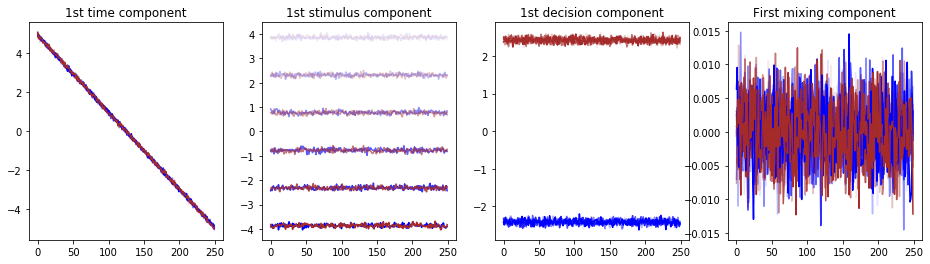

In [7]:
time = np.arange(T)

figure(figsize=(16, 4))
if D == 1:
    subplot(131)
    for s in range(S):
        for d in range(D):
            plot(time, Z['t'][0, s, :], alpha=transparency_s[s], color=color_d[d])
    title('1st time component')

    subplot(132)
    for s in range(S):
        for d in range(D):
            plot(time, Z['s'][0, s, :], alpha=transparency_s[s], color=color_d[d])
    title('1st stimulus component')

    subplot(133)
    for s in range(S):
        for d in range(D):
            plot(time, Z['st'][0, s, :], alpha=transparency_s[s], color=color_d[d])
    title('1st mixing component')

else:
    subplot(141)
    for s in range(S):
        for d in range(D):
            plot(time, Z['t'][0, s, d, :], alpha=transparency_s[s], color=color_d[d])
    title('1st time component')

    subplot(142)
    for s in range(S):
        for d in range(D):
            plot(time, Z['s'][0, s, d, :] + Z['st'][0, s, d, :], alpha=transparency_s[s], color=color_d[d])
    title('1st stimulus component')

    subplot(143)
    for s in range(S):
        for d in range(D):
            plot(time, Z['d'][0, s, d, :] + Z['dt'][0, s, d, :], alpha=transparency_s[s], color=color_d[d])
    title('1st decision component')

    subplot(144)
    for s in range(S):
        for d in range(D):
            plot(time, Z['sd'][0, s, d, :] + Z['sdt'][0, s, d, :], alpha=transparency_s[s], color=color_d[d])
    title('First mixing component')
show()

The 1st mixing component looks merely like noise. But to be sure, we can run a significance analysis:

In [8]:
significance_masks = dpca.significance_analysis(R, trialR, axis='t', n_shuffles=10,
                                                n_splits=10, n_consecutive=1)

Compute score of data:  . 

IndexError: tuple index out of range

In [ ]:
time = np.arange(T)

figure(figsize=(16, 4))

if D == 1:
    subplot(131)
    for s in range(S):
        plot(time, Z['t'][0, s, :], alpha=transparency_s[s], color=color_d[d])
    title('1st time component')

    subplot(132)
    for s in range(S):
        plot(time, Z['s'][0, s, :], alpha=transparency_s[s], color=color_d[d])
    imshow(significance_masks['s'][0][None, :], 
                         extent=[0, 250, np.amin(Z['s']) - 1, np.amin(Z['s']) - 0.5],
           aspect='auto', cmap='gray_r', vmin=0, vmax=1)
    ylim([np.amin(Z['s']) - 1, np.amax(Z['s']) + 1])
    title('1st stimulus component')

    subplot(133)
    for s in range(S):
        plot(time, Z['st'][0, s, :], alpha=transparency_s[s], color=color_d[d])

    imshow(significance_masks['st'][0][None, :],
                         extent=[0, 250, np.amin(Z['st']) - 1, np.amin(Z['st']) - 0.5],
           aspect='auto', cmap='gray_r', vmin=0, vmax=1)
    ylim([np.amin(Z['st']) - 1, np.amax(Z['st']) + 1])
    title('1st mixing component')
else:
    subplot(141)
    for s in range(S):
        for d in range(D):
            plot(time, Z['t'][0, s, d, :], alpha=transparency_s[s], color=color_d[d])
    title('1st time component')

    subplot(142)
    for s in range(S):
        for d in range(D):
            plot(time, Z['s'][0, s, d, :] + Z['st'][0, s, d, :], alpha=transparency_s[s], color=color_d[d])
    imshow(np.logical_or(significance_masks['s'][0][None, :], significance_masks['st'][0][None, :]), 
                         extent=[0, 250, np.amin(Z['s']) - 1, np.amin(Z['s']) - 0.5],
           aspect='auto', cmap='gray_r', vmin=0, vmax=1)
    ylim([np.amin(Z['s']) - 1, np.amax(Z['s']) + 1])
    title('1st stimulus component')

    subplot(143)
    for s in range(S):
        for d in range(D):
            plot(time, Z['d'][0, s, d, :] + Z['dt'][0, s, d, :], alpha=transparency_s[s], color=color_d[d])

    imshow(np.logical_or(significance_masks['d'][0][None, :], significance_masks['dt'][0][None, :]), 
                         extent=[0, 250, np.amin(Z['d']) - 1, np.amin(Z['d']) - 0.5],
           aspect='auto', cmap='gray_r', vmin=0, vmax=1)
    ylim([np.amin(Z['d']) - 1, np.amax(Z['d']) + 1])
    title('1st decision component')

    subplot(144)
    for s in range(S):
        for d in range(D):
            plot(time, Z['sd'][0, s, d, :] + Z['sdt'][0, s, d, :], alpha=transparency_s[s], color=color_d[d])
    imshow(np.logical_or(significance_masks['sd'][0][None, :], significance_masks['sdt'][0][None, :]), 
                         extent=[0, 250, np.amin(Z['sd']) - .05, np.amin(Z['sd']) - 0.03],
           aspect='auto', cmap='gray_r', vmin=0, vmax=1)
    ylim([np.amin(Z['sd']) - .05, np.amax(Z['sd']) + .05])
    title('First mixing component')
show()